# Figure

#### Author(s):
Sven Buder

#### History:
210410: Created


In [133]:
# Preamble for notebook 

# Compatibility with Python 3
from __future__ import (absolute_import, division, print_function)

try:
    %matplotlib inline
    %config InlineBackend.figure_format='retina'
except:
    pass

# Basic packages
import warnings
warnings.filterwarnings("ignore")
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
from astropy.table import Table, join
import astropy.units as u
from astropy.cosmology import FlatLambdaCDM
from sklearn import mixture
import scipy
import seaborn as sns

# Matplotlib and associated packages for plotting
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.patches as patches
from matplotlib import ticker

params = {
    'font.family'        : 'serif',
    'text.usetex'        : True, 
    'text.latex.preamble': [r'\usepackage{upgreek}', r'\usepackage{amsmath}'],
    }   
plt.rcParams.update(params)

In [95]:
def get_and_join_data(directory = '../data/'):
    
    # Join all data
    galah_dr3_main = Table.read(directory+'GALAH_DR3_main_allspec_v2.fits')
    galah_dr3_dynamics = Table.read(directory+'GALAH_DR3_VAC_dynamics_v2.fits')
    galah_dr3_gaiaedr3 = Table.read(directory+'GALAH_DR3_VAC_GaiaEDR3_v2.fits')
    galah_dr3_ages = Table.read(directory+'GALAH_DR3_VAC_ages_v2.fits')
    galah_dr3_rv = Table.read(directory+'GALAH_DR3_VAC_rv_v2.fits')
    data_12 = join(galah_dr3_main, galah_dr3_dynamics, keys='sobject_id')
    data_123 = join(data_12, galah_dr3_gaiaedr3, keys='sobject_id')
    data_1234 = join(data_123, galah_dr3_ages, keys='sobject_id')
    data = join(data_1234, galah_dr3_rv, keys='sobject_id')
    
    # get best rv and e_rv
    data['best_rv'] = np.zeros(len(data['sobject_id'])); data['best_rv'][:] = np.nan;
    data['best_rv'][data['use_rv_flag_1']==0] = data['rv_obst'][data['use_rv_flag_1']==0]
    data['best_rv'][data['use_rv_flag_1']==1] = data['rv_sme_v2'][data['use_rv_flag_1']==1]
    data['best_rv'][data['use_rv_flag_1']==2] = data['dr2_radial_velocity_1'][data['use_rv_flag_1']==2]

    data['best_e_rv'] = np.zeros(len(data['sobject_id'])); data['best_e_rv'][:] = np.nan;
    data['best_e_rv'][data['use_rv_flag_1']==0] = data['e_rv_obst'][data['use_rv_flag_1']==0]
    data['best_e_rv'][data['use_rv_flag_1']==1] = data['e_rv_sme'][data['use_rv_flag_1']==1]
    data['best_e_rv'][data['use_rv_flag_1']==2] = data['dr2_radial_velocity_error_1'][data['use_rv_flag_1']==2]
    
    # get best distance and 16th + 84th percentile
    data['best_d'] = np.zeros(len(data['sobject_id'])); data['best_d'][:] = np.nan;
    data['best_d_16'] = np.zeros(len(data['sobject_id'])); data['best_d_16'][:] = np.nan;
    data['best_d_50'] = np.zeros(len(data['sobject_id'])); data['best_d_50'][:] = np.nan;
    data['best_d_84'] = np.zeros(len(data['sobject_id'])); data['best_d_84'][:] = np.nan;

    data['best_d'][data['use_dist_flag']==0] = 1000.*data['distance_bstep'][data['use_dist_flag']==0]
    data['best_d_16'][data['use_dist_flag']==0] = 1000.*data['e16_distance_bstep'][data['use_dist_flag']==0]
    data['best_d_50'][data['use_dist_flag']==0] = 1000.*data['e50_distance_bstep'][data['use_dist_flag']==0]
    data['best_d_84'][data['use_dist_flag']==0] = 1000.*data['e84_distance_bstep'][data['use_dist_flag']==0]

    data['best_d'][data['use_dist_flag']==1] = data['r_med_photogeo'][data['use_dist_flag']==1]
    data['best_d_16'][data['use_dist_flag']==1] = data['r_lo_photogeo'][data['use_dist_flag']==1]
    data['best_d_50'][data['use_dist_flag']==1] = data['r_med_photogeo'][data['use_dist_flag']==1]
    data['best_d_84'][data['use_dist_flag']==1] = data['r_hi_photogeo'][data['use_dist_flag']==1]

    data['best_d'][data['use_dist_flag']==2] = data['r_med_geo'][data['use_dist_flag']==2]
    data['best_d_16'][data['use_dist_flag']==2] = data['r_lo_geo'][data['use_dist_flag']==2]
    data['best_d_50'][data['use_dist_flag']==2] = data['r_med_geo'][data['use_dist_flag']==2]
    data['best_d_84'][data['use_dist_flag']==2] = data['r_hi_geo'][data['use_dist_flag']==2]

    data['best_d'][data['use_dist_flag']==4] = 1000./data['parallax_corr'][data['use_dist_flag']==4]
    data['best_d_16'][data['use_dist_flag']==4] = 1000./(data['parallax_corr'][data['use_dist_flag']==4]+data['parallax_error'][data['use_dist_flag']==4])
    data['best_d_50'][data['use_dist_flag']==4] = 1000./(data['parallax_corr'][data['use_dist_flag']==4]-data['parallax_error'][data['use_dist_flag']==4])
    data['best_d_84'][data['use_dist_flag']==4] = 1000./data['r_hi_geo'][data['use_dist_flag']==4]

    data['theta_spherical'] = np.arctan2(data['R_Rzphi'], data['z_Rzphi'])
    data['rho_spherical'] = np.sqrt((data['R_Rzphi'])**2+(data['z_Rzphi'])**2)
    data['vrho_spherical'] = (data['R_Rzphi']*data['vR_Rzphi'] + data['z_Rzphi']*data['vz_Rzphi'])/data['rho_spherical']
    data['vtheta_spherical'] = (data['z_Rzphi']*data['vR_Rzphi'] - data['R_Rzphi']*data['vz_Rzphi'])/data['rho_spherical']

    return data

# test if joined data file already exists
try:
    data = Table.read('../../data/GALAH_DR3_all_joined_v2.fits')
except:
    data = get_and_join_data(directory = '../../data/')
    data.write('../../data/GALAH_DR3_all_joined_v2.fits')

In [96]:
# Selection basics

basic_cuts = (
    (data['flag_sp'] == 0) &
    (data['flag_fe_h'] == 0) &
    (data['best_d'] <= 10000.) &
    np.isfinite(data['L_Z']) &
    np.isfinite(data['ecc']) &
    np.isfinite(data['age_bstep'])
)

basic_cuts_mgalpha = (
    basic_cuts &
    (data['flag_alpha_fe'] == 0) &
    (data['flag_Mg_fe'] == 0)
)

def nissen_slope_mg_fe(fe_h):
    """
    Slope [Fe/H] vs. [Mg/Fe] as estimated from 2010A%26A...511L..10N
    
    -1/12 * [Fe/H] + 1/6
    
    """
    return -0.1/1.2*(fe_h)+(0.3 - 1.6*0.1/1.2)

def nissen_slope_alpha_fe(fe_h):
    """
    Slope [Fe/H] vs. [alpha/Fe] as estimated from 2010A%26A...511L..10N
    
    -0.2/1.2*(fe_h)+(0.325 - 1.6*0.2/1.2)
    
    -1/6 * [Fe/H] + 0.7/12
    
    """
    return -0.2/1.2*(fe_h)+(0.325 - 1.6*0.2/1.2)

def total_velocity(data):
    """
    return the total space velocity:
    
    sqrt(pow(rv_galah,2) + (pow(4.7623*r_est/1000.,2)*(pow(pmra,2) + pow(pmdec,2))))
    
    """
    return np.sqrt(
            (data['best_rv'])**2 + 
            (4.7623*data['best_d']/1000.)**2 * 
            ((data['pmra'])**2 + (data['pmdec'])**2)
        )

def tangential_velocity(data):
    return (4.7623*data['best_d']/1000.)*np.sqrt((data['pmra'])**2 + (data['pmdec'])**2)

rgb = (
    (data['teff'] < 5500) &
    (data['logg'] < 3.25)
)

msto = (
    (data['teff'] >= 5350) &
    (data['logg'] >= 3.5)
)

stars_with_high_vtot = (
    basic_cuts_mgalpha & 
    (total_velocity(data) > 180)
)

stars_with_high_vtan = (
    basic_cuts_mgalpha & 
    (tangential_velocity(data) > 180)
)

preliminary_low_alpha_halo = (
    basic_cuts_mgalpha &
    (total_velocity(data) > 180) &
    (data['fe_h'] >= -2.0) & (data['fe_h'] <= -0.4) &
    (data['Mg_fe'] < nissen_slope_mg_fe(data['fe_h'])) &
    (data['alpha_fe'] < nissen_slope_alpha_fe(data['fe_h']))
)

preliminary_high_alpha_halo = (
    basic_cuts_mgalpha &
    (total_velocity(data) > 180) &
    (data['fe_h'] >= -2.0) & (data['fe_h'] <= -0.4) &
    (data['Mg_fe'] >= nissen_slope_mg_fe(data['fe_h'])) &
    (data['alpha_fe'] >= nissen_slope_alpha_fe(data['fe_h']))
)

# Selection via [Mg/Cu] vs. [Na/Fe]
chem1 = (
    basic_cuts &
    (data['flag_Mg_fe'] == 0) &
    (data['flag_Na_fe'] == 0) &
    (data['flag_Cu_fe'] == 0) &
    (data['Mg_fe'] - data['Cu_fe'] > 0.5) &
    (data['Na_fe'] < -0.1)
)

# Selection via [Mg/Mn] vs. [Na/Fe]
chem2 = (
    basic_cuts &
    (data['flag_Mg_fe'] == 0) &
    (data['flag_Mn_fe'] == 0) &
    (data['flag_Na_fe'] == 0) &
    (np.abs(data['Mg_fe'] - data['Mn_fe'] - 0.5) <= 0.25) &
    (data['Na_fe'] < -0.1)
)

# Selection via [Mg/Mn] vs. [Na/Fe] + [Fe/H]
chem2_mp = (
    basic_cuts &
    (data['flag_Mg_fe'] == 0) &
    (data['flag_Mn_fe'] == 0) &
    (data['flag_Na_fe'] == 0) &
    (np.abs(data['Mg_fe'] - data['Mn_fe'] - 0.5) <= 0.25) &
    (data['Na_fe'] < -0.1) &
    (data['fe_h'] <= -0.5)
)


# Selection via [Mg/Mn] vs. [Al/Fe], like Das+2020 'blob' selection
chem3 = (
    basic_cuts &
    (data['flag_Mg_fe'] == 0) &
    (data['flag_Al_fe'] == 0) &
    (data['flag_Mn_fe'] == 0) &
    (np.abs(data['Al_fe'] - (-0.35)) <= 0.25) &
    (np.abs(data['Mg_fe'] - data['Mn_fe'] - 0.5) <= 0.25)
)

# Selection via [Mg/Mn] vs. [Al/Fe] + [Fe/H] like Das+2020 'metal-poor blob' selection
chem3_mp = (
    basic_cuts &
    (data['flag_Mg_fe'] == 0) &
    (data['flag_Al_fe'] == 0) &
    (data['flag_Mn_fe'] == 0) &
    (np.abs(data['Al_fe'] - (-0.35)) <= 0.25) &
    (np.abs(data['Mg_fe'] - data['Mn_fe'] - 0.5) <= 0.25) &
    (data['fe_h'] < -0.5)
)

# Selection via L_Z and J_R like Feuillet+2020
feuillet2020 = (
    basic_cuts &
    (data['L_Z'] >= -500) &
    (data['L_Z'] <= 500) &
    (data['J_R'] >= 30**2) &
    (data['J_R'] <= 50**2)
)


# Selection via L_Z and E like Helmi+2018
helmi2018 = (
    basic_cuts & 
    (data['L_Z'] > -1500) &
    (data['L_Z'] < 150) &
    (data['Energy'] > -1.8*10**5)
)

# Selection like Naidu+2020, excluding Sagitarius, Alpeh, high-alpha disk and then selection via eccentricity
#naidu2020_sagitarius = (data['L_Y'] < -0.3*data['L_Z'] - 2.5*10**3)
naidu2020_aleph = (
    (data['vT_Rzphi'] < -175) &
    (data['vT_Rzphi'] > 300) & 
    (np.abs(data['vR_Rzphi']) < 75) & 
    (data['fe_h'] > -0.8) & 
    (data['alpha_fe'] < 0.27)
)
naidu2020_highalphadisk = (
    (data['alpha_fe'] > 0.25 - 0.5*(data['fe_h'] + 0.7))
)
naidu2020 = (
    basic_cuts & 
    (data['flag_fe_h'] == 0) &
    (data['flag_alpha_fe'] == 0) &
    # Sagitarius
    (~naidu2020_aleph) &
    (~naidu2020_highalphadisk) &
    (data['ecc'] > 0.7)
)

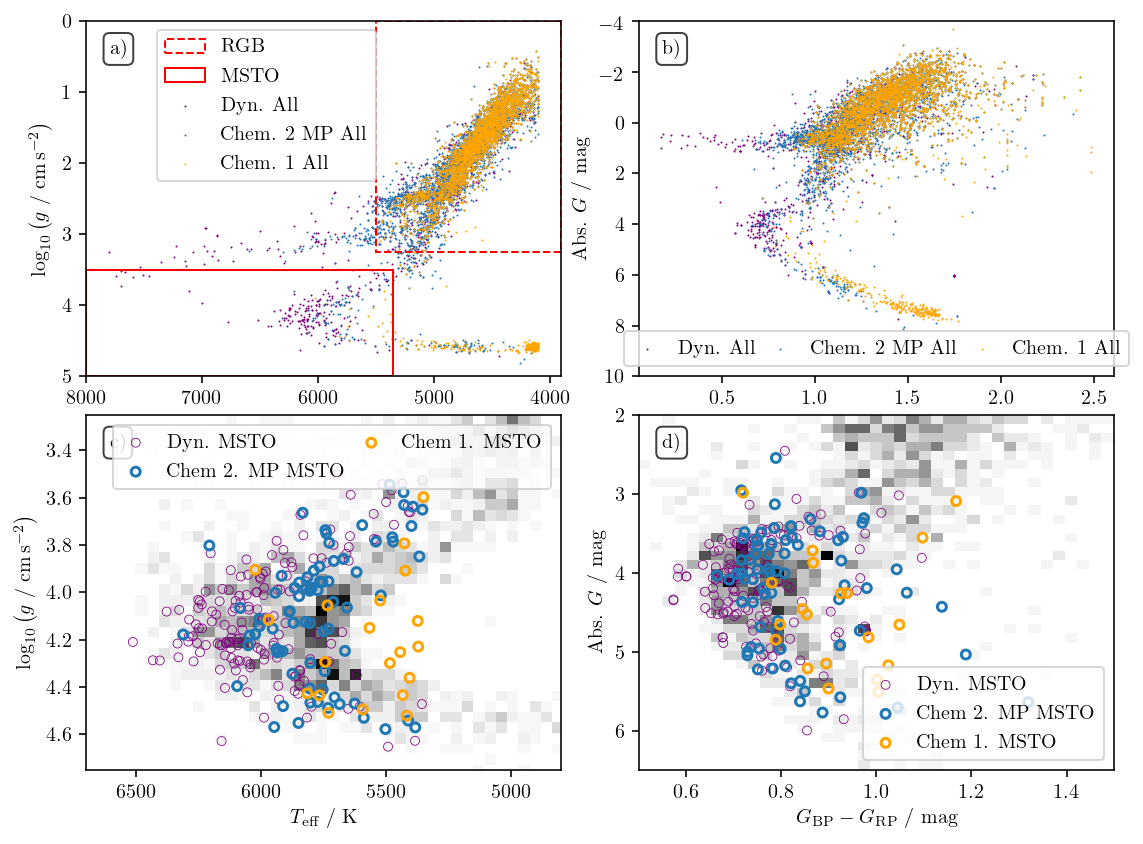

In [97]:
def plot_kiel_diagram():
    
    f, gs = plt.subplots(2,2,figsize=(8.3,6))
    
    # Panel a)
    ax=gs[0,0]
    kwargs_all = dict(lw=0, s=1)
    ax.scatter(
        data['teff'][feuillet2020],
        data['logg'][feuillet2020],
        label = 'Dyn. All',
        color='purple',**kwargs_all
    )
#     ax.scatter(
#         data['teff'][chem3],
#         data['logg'][chem3],
#         label = 'Chem. 3 All',
#         color='pink',**kwargs_all
#     )
    ax.scatter(
        data['teff'][chem2_mp],
        data['logg'][chem2_mp],
        label = 'Chem. 2 MP All',
        color='C0',**kwargs_all
    )
    ax.scatter(
        data['teff'][chem1],
        data['logg'][chem1],
        label = 'Chem. 1 All',
        c='orange',**kwargs_all
    )
    ax.set_xlim(8000,3900)
    ax.set_ylim(5,0)
    #ax.set_xlabel(r'$T_\text{eff}$~/~K')
    ax.set_ylabel(r'$\log_{10} \left( g\mathrm{~/~cm\,s^{-2}} \right)$')
    
    rect = patches.Rectangle((3900, 0), 5500-3900, 3.25, linewidth=1, edgecolor='r', ls='dashed', facecolor='none', label='RGB')
    ax.add_patch(rect)
    rect = patches.Rectangle((5350, 3.5), 8000-5350, 5-3.5, linewidth=1, edgecolor='r', facecolor='none', label='MSTO')
    ax.add_patch(rect)

    ax.legend(loc=(0.15,0.55))
    ax.text(0.05,0.95,'a)',transform=ax.transAxes,ha='left',va='top',bbox=dict(boxstyle='round', facecolor='w', alpha=0.75))
    
    # Panel b)
    ax=gs[0,1]
    kwargs_all = dict(lw=0, s=1)
    ax.scatter(
        data['bp_rp'][feuillet2020],
        data['phot_g_mean_mag'][feuillet2020] - 5*np.log10(data['best_d'][feuillet2020]/10.),
        label = 'Dyn. All',
        color='purple',**kwargs_all
    )
#     ax.scatter(
#         data['bp_rp'][chem3],
#         data['phot_g_mean_mag'][chem3] - 5*np.log10(data['best_d'][chem3]/10.),
#         label = 'Chem. 3 All',
#         color='pink',**kwargs_all
#     )
    ax.scatter(
        data['bp_rp'][chem2_mp],
        data['phot_g_mean_mag'][chem2_mp] - 5*np.log10(data['best_d'][chem2_mp]/10.),
        label = 'Chem. 2 MP All',
        color='C0',**kwargs_all
    )
    ax.scatter(
        data['bp_rp'][chem1],
        data['phot_g_mean_mag'][chem1] - 5*np.log10(data['best_d'][chem1]/10.),
        label = 'Chem. 1 All',
        c='orange',**kwargs_all
    )
    ax.set_ylim(10,-4)
    #ax.set_xlabel(r'$G_\text{BP} - G_\text{RP}$~/~mag')
    ax.set_ylabel(r'Abs. $G$~/~mag')

    ax.legend(loc='lower center',ncol=3,handlelength=1.5,columnspacing=0.5)
    ax.text(0.05,0.95,'b)',transform=ax.transAxes,ha='left',va='top',bbox=dict(boxstyle='round', facecolor='w', alpha=0.75))

    # Panel c)
    ax=gs[1,0]
    ax.hist2d(
        data['teff'][basic_cuts & (total_velocity(data) > 180)],
        data['logg'][basic_cuts & (total_velocity(data) > 180)],
        bins = (np.linspace(4750,6500,40),np.linspace(3.25,5,40)),
        #norm=LogNorm(),
        cmap='Greys',
        label = '$v_\text{tot} > 180\,\mathrm{km\,s^{-1}}$',
    );
    ax.scatter(
        data['teff'][feuillet2020 & msto],
        data['logg'][feuillet2020 & msto],
        label = 'Dyn. MSTO',s=20, lw=0.4,
        facecolors='none', edgecolors='purple'
    )
    ax.scatter(
        data['teff'][chem2_mp & msto],
        data['logg'][chem2_mp & msto],
        label = 'Chem 2. MP MSTO',s=20, lw=1.5,
        facecolors='none',edgecolors='C0'
    )    
#     ax.scatter(
#         data['teff'][chem3_mp & msto],
#         data['logg'][chem3_mp & msto],
#         label = 'Chem 3. MP MSTO',s=20, lw=1.5,
#         facecolors='none',edgecolors='pink'
#     )
    ax.scatter(
        data['teff'][chem1 & msto],
        data['logg'][chem1 & msto],
        label = 'Chem 1. MSTO',s=20, lw=1.5,
        facecolors='none', edgecolors='orange'
    )
    ax.set_xlim(6700,4800)
    ax.set_ylim(4.75,3.25)
    ax.set_xlabel(r'$T_\text{eff}$~/~K')
    ax.set_ylabel(r'$\log_{10} \left( g\mathrm{~/~cm\,s^{-2}} \right)$')

    ax.legend(loc='upper right',ncol=2,handlelength=1.5,columnspacing=0.5)
    ax.text(0.05,0.95,'c)',transform=ax.transAxes,ha='left',va='top',bbox=dict(boxstyle='round', facecolor='w', alpha=0.75))
    
    ax=gs[1,1]
    ax.hist2d(
        data['bp_rp'][basic_cuts & (tangential_velocity(data) > 180)],
        data['phot_g_mean_mag'][basic_cuts & (tangential_velocity(data) > 180)] - 5*np.log10(data['best_d'][basic_cuts & (tangential_velocity(data) > 180)]/10.),
        bins = (np.linspace(0.5,1.5,40),np.linspace(2,6.5,40)),
        #norm=LogNorm(),
        cmap='Greys',
        label = '$v_\text{tot} > 180\,\mathrm{km\,s^{-1}}$'
    );
    ax.scatter(
        data['bp_rp'][feuillet2020 & msto],
        data['phot_g_mean_mag'][feuillet2020 & msto] - 5*np.log10(data['best_d'][feuillet2020 & msto]/10.),
        label = 'Dyn. MSTO',s=20, lw=0.4,
        facecolors='none', edgecolors='purple'
    )
    ax.scatter(
        data['bp_rp'][chem2_mp & msto],
        data['phot_g_mean_mag'][chem2_mp & msto] - 5*np.log10(data['best_d'][chem2_mp & msto]/10.),
        label = 'Chem 2. MP MSTO',s=20, lw=1.5,
        facecolors='none',edgecolors='C0'
    )
#     ax.scatter(
#         data['bp_rp'][chem3_mp & msto],
#         data['phot_g_mean_mag'][chem3_mp & msto] - 5*np.log10(data['best_d'][chem3_mp & msto]/10.),
#         label = 'Chem 3. MP MSTO',s=20, lw=1.5,
#         facecolors='none',edgecolors='pink'
#     )
    ax.scatter(
        data['bp_rp'][chem1 & msto],
        data['phot_g_mean_mag'][chem1 & msto] - 5*np.log10(data['best_d'][chem1 & msto]/10.),
        label = 'Chem 1. MSTO',s=20, lw=1.5,
        facecolors='none', edgecolors='orange'
    )
    ax.set_xlim(0.5, 1.5)
    ax.set_ylim(6.5,2)
    ax.set_xlabel(r'$G_\text{BP} - G_\text{RP}$~/~mag')
    ax.set_ylabel(r'Abs. $G$~/~mag')

    ax.legend(loc='lower right',handlelength=1.5,columnspacing=0.5)
    ax.text(0.05,0.95,'d)',transform=ax.transAxes,ha='left',va='top',bbox=dict(boxstyle='round', facecolor='w', alpha=0.75))
    
    plt.tight_layout(w_pad=0,h_pad=0)
    plt.savefig('kiel_cmd.png',dpi=300,bbox_inches='tight')

plot_kiel_diagram()

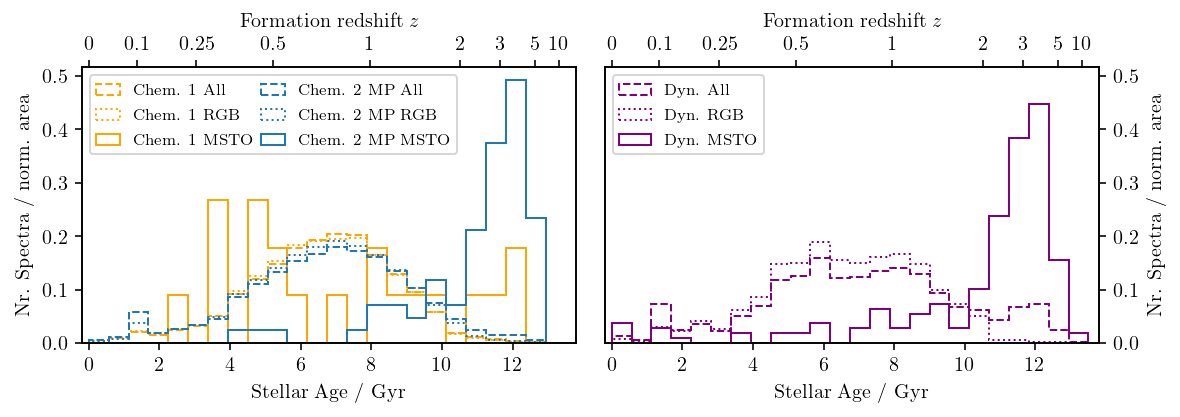

In [147]:
def plot_age_histogram():

    cosmo = FlatLambdaCDM(H0=67.4, Om0=0.315)
    redshifts = np.array([0,0.1,0.25,0.5,1,2,3,5,10])
    #redshifts = np.array([0,0.1,0.25,0.5,0.8,1.3,2,3,5,10])
    agevals = np.arange(0, 13.5, 0.1)
    redshiftticks = [cosmo.lookback_time(redshift).to_value() for redshift in redshifts]

    f, gs = plt.subplots(1,2,figsize=(8.3,3),sharex=True,sharey=True)

    age_bins = np.linspace(0,13.5,25)

    kwargs = dict(histtype = 'step', density=True)

    ax=gs[0]

    # chemically selected stars
    counts, bins = np.histogram(data['age_bstep'][chem1], bins=age_bins)
    ax.hist(bins[:-1], bins, weights=counts, color='orange', ls='dashed', label='Chem. 1 All',**kwargs)

    counts, bins = np.histogram(data['age_bstep'][(chem1 & rgb)], bins=age_bins)
    ax.hist(bins[:-1], bins, weights=counts, color='orange', ls='dotted', label='Chem. 1 RGB',**kwargs)

    counts, bins = np.histogram(data['age_bstep'][(chem1 & msto)], bins=age_bins)
    ax.hist(bins[:-1], bins, weights=counts, color='orange', label='Chem. 1 MSTO',**kwargs)

    # chemically selected stars
    counts, bins = np.histogram(data['age_bstep'][chem2_mp], bins=age_bins)
    ax.hist(bins[:-1], bins, weights=counts, color='C0', ls='dashed', label='Chem. 2 MP All',**kwargs)

    counts, bins = np.histogram(data['age_bstep'][(chem2_mp & rgb)], bins=age_bins)
    ax.hist(bins[:-1], bins, weights=counts, color='C0', ls='dotted', label='Chem. 2 MP RGB',**kwargs)

    counts, bins = np.histogram(data['age_bstep'][(chem2_mp & msto)], bins=age_bins)
    ax.hist(bins[:-1], bins, weights=counts, color='C0', label='Chem. 2 MP MSTO',**kwargs)

#     # chemically selected stars
#     counts, bins = np.histogram(data['age_bstep'][chem3_mp], bins=age_bins)
#     ax.hist(bins[:-1], bins, weights=counts, color='pink', ls='dashed', label='Chem. 3 MP All',**kwargs)

#     counts, bins = np.histogram(data['age_bstep'][(chem3_mp & rgb)], bins=age_bins)
#     ax.hist(bins[:-1], bins, weights=counts, color='pink', ls='dotted', label='Chem. 3 MP RGB',**kwargs)

#     counts, bins = np.histogram(data['age_bstep'][(chem3_mp & msto)], bins=age_bins)
#     ax.hist(bins[:-1], bins, weights=counts, color='pink', label='Chem. 3 MP MSTO',**kwargs)

    ax.legend(ncol=2,fontsize=8,loc='upper left',handlelength=1.5,columnspacing=0.5)
    ax.set_xlim(-0.2,13.8)
    ax.set_xlabel('Stellar Age / Gyr')
    ax.set_ylabel('Nr. Spectra / norm. area')

    ax1y = ax.twiny()
    ax1y.set_xticks(redshiftticks)
    ax1y.set_xticklabels(['{:g}'.format(redshift) for redshift in redshifts])
    ax1.set_xlim(-0.2, 13.8)
    ax1y.set_xlim(-0.2, 13.8)
    ax1y.set_xlabel('Formation redshift $z$')
    ax1.set_xlabel('Stellar Age / Gyr')
    ax1.minorticks_on()
    
    ax=gs[1]
    # dynamically selected stars
    counts, bins = np.histogram(data['age_bstep'][feuillet2020], bins=age_bins)
    ax.hist(bins[:-1], bins, weights=counts, color='purple', ls='dashed', label='Dyn. All',**kwargs)

    counts, bins = np.histogram(data['age_bstep'][(feuillet2020 & rgb)], bins=age_bins)
    ax.hist(bins[:-1], bins, weights=counts, color='purple', ls='dotted', label='Dyn. RGB',**kwargs)

    counts, bins = np.histogram(data['age_bstep'][(feuillet2020 & msto)], bins=age_bins)
    ax.hist(bins[:-1], bins, weights=counts, color='purple', label='Dyn. MSTO',**kwargs)

    ax.yaxis.set_tick_params(labelright=1,right=1,labelleft=0,left=0)
    ax.yaxis.set_label_position('right') 
    ax.legend(fontsize=8,loc='upper left')
    ax.set_xlim(-0.2,13.8)
    ax.set_xlabel('Stellar Age / Gyr')
    ax.set_ylabel('Nr. Spectra / norm. area')

    ax1y = ax.twiny()
    ax1y.set_xticks(redshiftticks)
    ax1y.set_xticklabels(['{:g}'.format(redshift) for redshift in redshifts])
    ax1.set_xlim(-0.2, 13.8)
    ax1y.set_xlim(-0.2, 13.8)
    ax1y.set_xlabel('Formation redshift $z$')
    ax1.set_xlabel('Stellar Age / Gyr')
    ax1.minorticks_on()

    plt.tight_layout()
    plt.savefig('age_histogram.png',dpi=200,bbox_inches='tight')

plot_age_histogram()